In [ ]:
import numpy as np
from scipy.ndimage import gaussian_filter1d as g1d
from scipy.stats import norm
import matplotlib.pylab as plt
from scipy.interpolate import interp1d
from matplotlib import cm


# Intra-revolution polarization

Polarization develops after detector switch-on. It is not guaranteed that at the revolution start the detector is completely unpolarized. This usually happens at the revolution start, but may also happen in the middle of the revolution, e.g. following IREM reset. 
Short off-time cases partial recovery of the gain. Longer off-time recovers the gain to the same state at which it was before. The fact that some basic level is recovered after some hours, indicates that some stationary state exists and is observed at the beginning of the orbit. It is still not certain if this state is completely unpolarized.

After about 2 days (near the orbit end) the evolution typically stops. This indicates that a new stationary state is reached. It is not reached in all orbits, and this effect also evolves with mission lifetime.

<img src="https://volodymyrss.github.io/imgb/lines_rev.png.1422363474.f83d1aa7f1" height="400px">

Polarization affects high-RT and low-RT data differently as polarization progresses after switch-on:
* low-RT transport is progressively degraded (by about 2%)
* high-RT transport is progressively improved (by about 2%)

<img src="https://volodymyrss.github.io/imgb/rtevo665.png.1438160162.7256945645" height="400px">

This can be also seen in the PHA-RT diagram (left: in the beginning of the revoluion, right: near the end):

<img src="https://volodymyrss.github.io/imgb/early_late_bipar.jpeg.1422893544.c96ba39f09" height="400px">



Normally, high-RT counts correspond to high-depth interactions.
Change in field inevitably affects both RT and PHA. 

2% decrease in low-RT charge collection corresponds to about 2% change in field. # check???

Text(0, 0.5, 'RT (ISGRI Rise Time channel)')

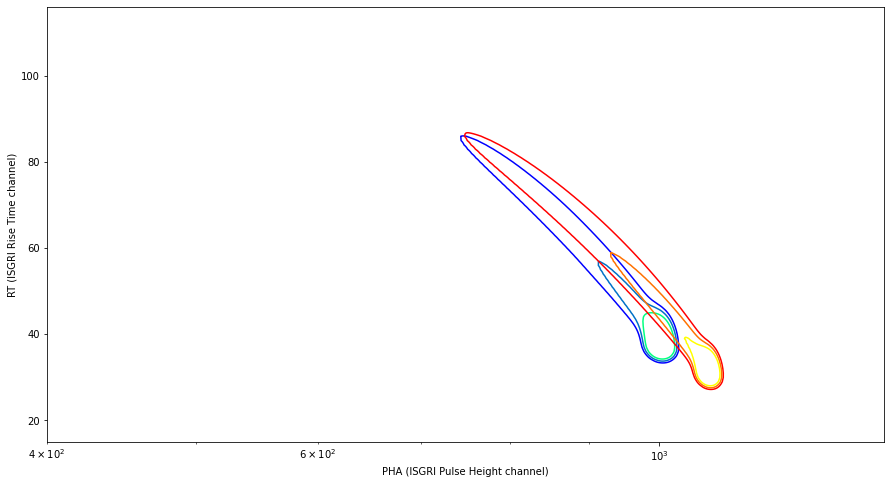

In [82]:
bip = np.zeros_like(pha_2d, dtype=float)

det_base = bipar_model.detector()

lrt_lines = []

plt.figure(figsize=(15, 8))

cmap_by_loss = {
    0: cm.winter,
    1: cm.autumn
}


#for tau_loss_factor in np.logspace(-1., 0, 3):
for i_loss, V_loss_factor in enumerate(np.logspace(-0.2, 0, 2)):
    det = bipar_model.detector()
    #det.tau_e = det_base.tau_e * tau_loss_factor
    det.V = det_base.V * V_loss_factor

    #for en in [511]:
    for en in [59, 511]:
        _bip = bipar_model.make_bipar_monoenergetic(det, en).transpose()

        for rt1, rt2 in [(15,30), (50,70)]:
            ltr_bip = _bip[rt1:rt2, :].sum(0)
            lrt_lines.append(
                dict(
                    rt1=rt1,
                    rt2=rt2,
                    energy=en,
                    tau_e=det.tau_e,
                    V=det.V,
                    mean_pha=np.sum(pha_2d[0,:]*ltr_bip)/np.sum(ltr_bip),
                    bip=_bip
                )
                )
        
        bip += _bip / np.nanquantile(_bip[_bip>_bip.max()/100].flatten(), 0.5)


        plt.contour(pha_2d, rt_2d, _bip**0.5, levels=np.logspace(-0.5, -0.3, 3)*np.nanmax(_bip**0.5),
                    cmap=cmap_by_loss[i_loss]
        )

plt.semilogx()
plt.xlim([400, 1400])
#plt.xlim([70, 1200])
plt.ylim([15, 116])

plt.xlabel('PHA (ISGRI Pulse Height channel)')
plt.ylabel('RT (ISGRI Rise Time channel)')

# for vl in lrt_lines:
#     plt.axvline(vl['mean_pha'])

/tmp/ipykernel_421266/4224400571.py:9: RuntimeWarning: invalid value encountered in true_divide
  pha = (_bip*pha_2d).sum(1)/_bip.sum(1)


(15.0, 116.0)

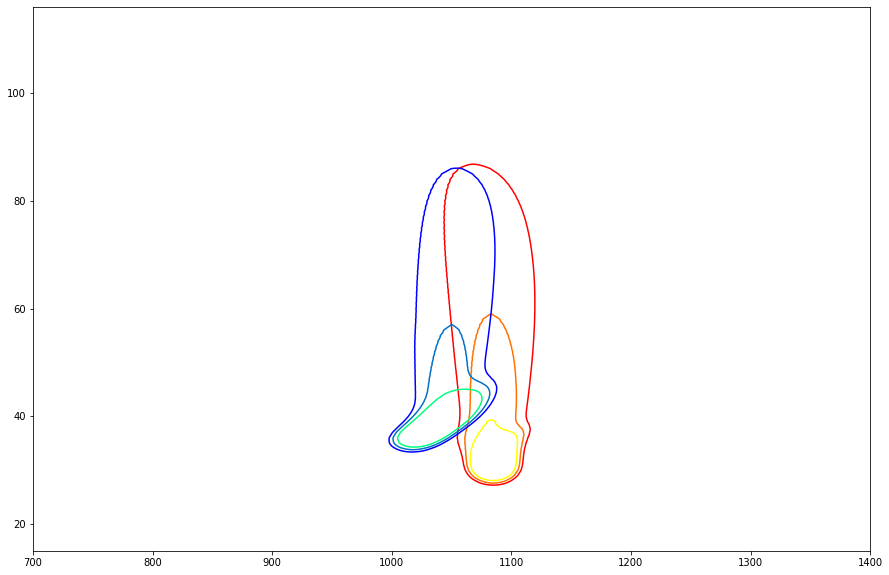

In [28]:
plt.figure(figsize=(15,10))

for pair in [[lrt_lines[-1]['bip'], lrt_lines[-6]['bip']],
             [lrt_lines[0]['bip'], lrt_lines[4]['bip']]]:
    cmaps = [cm.winter, cm.autumn]*4
    _bip = pair[0]

    rt = rt_2d[:,0]
    pha = (_bip*pha_2d).sum(1)/_bip.sum(1)
    m = ~np.isnan(pha)
    lut2 = interp1d(rt[m], pha[m]/np.nanmax(pha), bounds_error=False)

    for _bip in pair:
        plt.contour(pha_2d/np.outer(lut2(rt), np.ones(2048)), rt_2d, _bip**0.5, levels=np.logspace(-0.5, -0.3, 3)*np.nanmax(_bip**0.5),
                    cmap=cmaps.pop())


plt.xlim([700, 1400])
plt.ylim([15, 116])

#plt.xlabel()

#plt.semilogx()





There are not many ways to explain this. The best I can suggest for now is changes in detector homogenuity: polarization and/or charge carrier properties.

#TODO: combine and estimate field and detector properties inhomegenuity effect
#TODO: model field inhomogenuity to see what it does?

* In particular, it does not appear possible to achieve improvement in the high-RT collection in this way.
The tracks can never cross. An idea to achieve this was by stretiching the RT, which goes part of the way, but not enough.
* The RT shift at low RT is incompatible with observations

Inhomogenous field may be used to explain it.

Specifically, increase of field at higher depth and decrease at lower depth might produce the desired effects.
